# 神经网络训练技巧

| ![](../../_static/logo/megvii-32.svg) [在 MegStudio 运行](https://studio.brainpp.com/project/#) | ![](../../_static/logo/github-32.svg) [查看源文件](https://github.com/MegEngine/Documentation/blob/main/source/getting-started/beginner/neural-network-traning-tricks.ipynb) |
| --- | --- |

通过引入（卷积）神经网络模型，我们在 CIFAR-10 图片分类任务上已经能够达到 60% 左右的分类准确率。但是，探索从未停止！

在本次的教程中，我们会接触到神经网络模型训练过程中的部分常见技巧，并尝试对其原理做出一定的解释。

请先运行下面的代码，检验你的环境中是否已经安装好 MegEngine（[安装教程](https://megengine.org.cn/doc/stable/zh/user-guide/install/)）：

In [1]:
import megengine

print(megengine.__version__)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import megengine.autodiff as autodiff
import megengine.data as data
import megengine.data.transform as T
import megengine.functional as F
import megengine.module as M
import megengine.optimizer as optim

1.4.0


## 数据预处理（Preprocessing）

在机器学习领域，由于不同的机器学习算法和模型对于数据中的信息利用程度不同（回想一下线性分类器和 CNN 分类器），因此我们需要利用数据领域相关的知识使机器学习算法达到最佳性能，即进行特征工程（Feature Engineering），利用特征来对原始数据来进行更好的表达。机器学习坊间传闻着这一句话：“特征工程领域数据和特征决定了机器学习的上限，而模型和算法只是逼近这个上限而已”。（可以查看 Kaggle 提供的 [特征工程教程](https://www.kaggle.com/learn/feature-engineering) ）我们在之前教程的 AlexNet 模型代码中也存在着 `feature` 和 `classifier` 两部分，可以认为前半部分是在利用深度学习模型进行特征的提取和处理，而后半部分是传统的分类器。实际上，在将数据真正输入到深度学习模型之前，我们还可以提前进行一定程度的预处理。

我们在上一个教程中，利用 MegEngine 中的 `data.transform.Resize` 实现了对 CIFAR-10 输入数据形状的缩放，使之可以满足原本用于 ImageNet 的模型对输入形状的要求。图片形状的缩放属于数据预处理方式的一种，存在着包括双线性插值采样在内的不同算法实现。除了改变数据的形状，我们也可以直接对特征值进行一定的处理，比较常见的一种做法是特征缩放。

### 特征缩放（Feature Scaling）

特征缩放通常指将给定数据集的不同特征转换为相似的尺度，一些机器学习算法对于这样的预处理方式有着较强的依赖。

回忆一下我们的一元线性回归模型 $y = w \cdot x + b$ 进行参数学习的过程，通常 $w$ 总是能更快地比 $b$ 先接近理想值，这是为什么呢？

- 在进行梯度下降时，我们对于不同的参数 $w$ 和 $b$, 使用了相同的学习率 `lr`；
- 但是由于输入特征在尺度上的差异（一个是 $x$, 一个是常数 $1$ ），影响到了实际更新的步长。

再比如我们进行波士顿房价预测时，假设一个特征 $x_1$ 指代房屋面积，范围是 $(500, 5000)$; 另一个特征 $x_2$ 是房间数量，范围是 $(1, 10)$.

- 很显然，如果要进行房价预测，理想中最终得到的 $w_1$ 和 $w_2$ 可能会在不同的数量级；
- 在进行前向计算时，由于 $x_1$ 和 $x_2$ 的尺度差异，其对于最终线性输出的结果影响能力差异巨大；
- 不同特征 $x_1$ 和 $x_2$ 的量纲（或者说尺度范围）差异，也会直接地影响到对应参数的梯度更新幅度。

如果我们能够按照一定的规则，将不同特征的值都缩放到相同的范围，比如 $(0, 1)$, 就能够避免尺度不同带来的影响。

### 与梯度下降算法的关系

借助下面这张图，我们能进行更加直观的理解。**具有相似尺度的特征在进行梯度更新时步伐一致，可以帮助梯度下降更快地收敛到最小值** ：

![normalization](../../_static/images/normalization.png)

上图来自《[Gradient Descent Algorithm and Its Variants](https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3)》，我们可以看出：

- 这是一个等高线图，我们可以理解成横轴和纵轴是参数 $w$ 和 $b$ , 高度表示损失，理想情况下，我们需要往中间的最低点做梯度下降；
- 如果特征的分布是不标准（不均匀）的，随着参数的更新，最优的梯度下降方向将变得越来越“窄”；
- 假设每次都进行同等步长的梯度下降，左图容易导致走出一个 Z 字形状，相较于右图达到收敛需要更多的更新次数。

特征缩放的具体处理方式有很多种，我们将着重关注其中一种情况（感兴趣的读者可自行进行这方面知识的拓展）。

比如，对于由图片组成的数据集（比如 CIFAR10），我们可以进行 z-score normalization 处理：

- 将每个图像的像素点首先减去所有图像均值的像素点 `mean`, 然后再除以标准差 `std`;
- 这样可以保证所有的图像分布都相似，也就是在训练的时候更容易收敛；
- 但是需要注意，不同图像数据集的 `mean` 和 `std` 是不一样的，通常需要进行统计；
- 对于具有多通道的图像，我们通常会针对每个通道去计算不同的 `mean` 和 `std` 值。

MegEngine 的 `functional` 模块中，提供 `mean()`, `std()` 等常见的统计方法，有助于计算。

MegEngine 的 `data.transform` 模块中，提供了 `Normalize` 方法，我们在下面就会看到如何使用。 

- 在机器学习领域，还有着更多的对数据进行预处理的方法，比如 PCA 和白化等等；
- 有些时候一些复杂的处理需要借助其它的框架和脚本来完成，比如机器学习库 Scikit-Learn 提供了[预处理教程](https://scikit-learn.org/stable/modules/preprocessing.html) 和对应实现 。

### 数据增广（Data Augmentation）

在 MegEngine 的 `data.transfrom` 模块中，还提供了非常多的常见数据处理接口以供使用，一种有效的用途是用作数据增广（Data Augmentation）。

- 深度学习之所以有效，除了 “模型” 和 “算法” 之外，离不开 “数据” 的帮助；
- 我们喂入神经网络数据的数量多少和质量好坏，将会对最终模型的预测效果产生影响。

简单来说，如果可以对位置、视角、大小、照明等不同情况下的图片进行稳健的分类，则说明神经网络模型具备这些方面的不变性，前提是它需要 “见多识广”。
自然地，想要训练出足够好的模型，就需要喂入足够好的数据，这意味着我们需要对数据进行一定程度的增强，让模型能够得到更加充分的锻炼。
数据增广操作可以在机器学习 Pipeline 不同的位置执行，我们有两种思路：

- 线下增强（Offline augmentation）：即事先执行好所有转换，等同于对整个数据集提前处理。这种方法适用于规模比较小的数据集，因为它实质上会增大数据集的规模；
- 线上增强（Online augmentation）：即在当前 Batch 的数据喂入模型之前进行转换，这种操作可以避免数据规模爆炸带来的负面影响。

使用 MegEngine 的 `data.transform` 模块对数据进行增强，即采用了上述第二种策略。

下面我们将以图片数据为例，展示一下常见的增强操作：

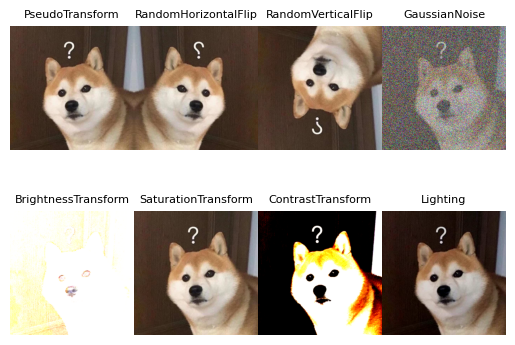

In [2]:
trans = [
    T.PseudoTransform(),  # 伪变换，仍然是原图
    T.RandomHorizontalFlip(prob=1), 
    T.RandomVerticalFlip(prob=1),
    T.GaussianNoise(),
    T.BrightnessTransform(10),
    T.SaturationTransform(10),
    T.ContrastTransform(10),
    T.Lighting(1)
]

for index, tran in enumerate(trans):
    image = plt.imread("../../_static/images/chai.jpg")
    transformed_image = tran.apply(image)
    plt.subplot(241+index)
    plt.axis('off')
    plt.title(tran.__class__.__name__, size=8)
    plt.subplots_adjust(wspace =0, hspace =0)
    plt.imshow(transformed_image)

plt.show()

我们仅对图片数据的特征进行了一些处理，而对应的标签无需做出改变，如你所见，上面变换后的图片仍然能分辨出是柴犬图。

需要提醒的是，MegEngine 的图像处理接口底层调用了 OpenCV, 而不是 PIL 库。

### 使用 Compose 组合处理

我们还可以使用 `transform.Compose` 来组合一些已有的变化，比如同时进行水平和垂直的翻转：

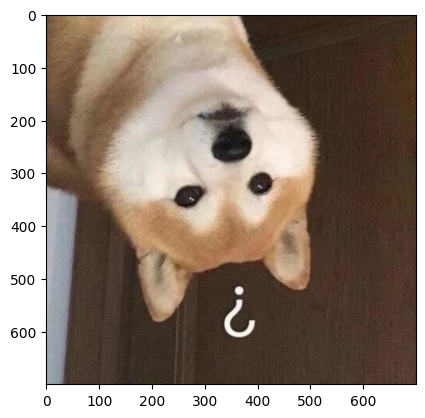

In [3]:
hv_clip = T.Compose([
    T.RandomHorizontalFlip(prob=1), 
    T.RandomVerticalFlip(prob=1),
])

image = plt.imread("../../_static/images/chai.jpg")
transformed_image = hv_clip.apply(image)
plt.imshow(transformed_image)
plt.show()

### 与 Dataloader 结合使用

这些操作还可以结合在 `Dataloader` 中对成批的数据使用，调用起来非常方便：

```python
dataset = ...
sampler = ...

transform = T.Compose([
        T.Resize(224),
        T.RandomHorizontalFlip(),
        # ...
        T.Normalize(),
        T.ToMode('CHW'),
])

dataloader = data.DataLoader(
    dataset,
    sampler,
    transform,
)
```

我们在之前的教程中已经见过了类似的用法，因此不再赘述。

你也可以将更多常见的数据增强功能实现到 MegEngine 中（欢迎成为 `data.transform` 贡献者～）。

## 随机初始化

我们在学习 `module` 模块的时候接触过了许多不同的权重初始化策略，也了解了如何去自定义初始化策略。问题是：为什么要这样做？

现在一起来思考一下，全连接神经网络使用零初始化策略时，具体发生了什么：

- 在同一个线性层中，每个神经元都接受了前一层所有神经元的输出作为输入；
- 如果该层的每个神经元都采用了相同的初始化策略，这意味着当前层每个神经元进行的计算是完全一致的；
- 同样地，如果有多个线性层，下一层的每个神经元会将当前层这些完全一致的输出都作为自己的输入...

通常模型的结构是固定的，采用梯度下降这种确定性优化算法时，意味着在前向传播和反向传播的过程中，每个隐含层内部的相邻神经元都在做完全相同的计算和更新，做了大量的重复劳动。
这与我们希望不同的神经元能学到不同的特征信息，或起到不同的表征作用的想法相违背， “世界上没有完全相同的两片树叶”，神经网络模型中也不应该有作用完全一样的神经元。
因此，我们必须采用随机初始化策略，来“打破”原有的对称性。

### 什么是科学的初始化方式？

- **如何进行“随机”才是最有效的呢？** 通常我们会假设数据的分布具备一定的概率先验，从统计的视角设计出有意义的初始化策略，比如让初始化的参数满足均匀分布、或者是正态分布。

- **随机初始化的值范围又该如何选定呢？** 如果设置得太大或太小，将会导致梯度出现爆炸或者消失的情况，在反向传播时无法很好地向后流动。为了确定合适的初始化方式，研究人员提出了 `xavier` 和 `msra` 等初始化策略，并被广泛实践（想要了解原理的话可以去阅读对应的论文）。

在 MegEngine 的 `module.init` 模块中，实现了这些常见的初始化策略：

- `megengine.module.init.xavier_uniform_`
- `megengine.module.init.xavier_normal_`
- `megengine.module.init.msra_uniform_`
- `megengine.module.init.msra_normal_`

我们无法证明哪一种初始化策略一定是最优的，直到目前为止，提出更通用更好用的初始化策略依旧是一项艰巨的任务。

好消息是，接下来我们将介绍 Batch Normalization, 从某种意义上来说，它可以减少我们对参数初始化的依赖。

## Batch Normalization

在本次教程的一开始，提到了可以通过 `data.transform.Normalize` 对输入数据进行预处理，对加速模型收敛很有帮助。

回忆一下在 MegEngine 中采取的 mini-batch 梯度下降策略：

- 把数据分为若干个 mini-batch，每个 mini-batch 的数据共同决定了本次梯度的方向，在参数更新时减少了随机性；
- 另一方面因为 batch size 与整个数据集的规模相比小了很多，因此计算量也下降了很多，这样可以避免训练时爆掉内存。

这个思路也可以运用在神经网络的训练过程中，即我们在进行一层前向计算后，对 mini-batch 的数据进行一次 `Normalization`, 用来重新调整数据分布。

回忆一下，在 VGG 系列模型中可根据 Conv2d(->BatchNorm2d)->ReLU->MaxPool2d 的区别将模型分为带 BN 的版本和不带 BN 的版本。

对于 CNN 模型，BN 的操作是分别在各个特征维度之间进行的，也就是说各个通道 $C$ 分别进行 Batch Normalization 操作。

- 在使用 BN 的情况下，即使一开始的权重初始化策略很糟糕，也能够通过各层之间的 BN 操作来重新调整，因此减少了对其对依赖；
- BN 还能够让损失更快地收敛，这意味着我们可以设置一个比较大的学习率，在较短的时间内取得不错的训练效果；
- 由于 BN 使用了 Batch 规模的数据进行统一的标准化，一定程度上加强了训练出的模型的泛化能力；
- 批数据和全量数据的均值和方差存在着差异，如果想要发挥出 Batch Normalization 的优势，Batch size 的值不能设置得过小。

**实际的 BN 工程实现可能没有以上描述的这么简单（[查看原始论文](https://arxiv.org/abs/1502.03167)）。** 对比前面教程实现的 AlexNet 模型，我们尝试加上 BN 层看看效果：

In [4]:
class AlexNetBN(M.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.features = M.Sequential(
            M.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            M.BatchNorm2d(64),   # BN
            M.ReLU(),
            M.MaxPool2d(kernel_size=3, stride=2),
            M.Conv2d(64, 192, kernel_size=5, padding=2),
            M.BatchNorm2d(192),  # BN
            M.ReLU(),
            M.MaxPool2d(kernel_size=3, stride=2),
            M.Conv2d(192, 384, kernel_size=3, padding=1),
            M.BatchNorm2d(384),  # BN
            M.ReLU(),
            M.Conv2d(384, 256, kernel_size=3, padding=1),
            M.BatchNorm2d(256),  # BN
            M.ReLU(),
            M.Conv2d(256, 256, kernel_size=3, padding=1),
            M.BatchNorm2d(256),  # BN
            M.ReLU(),
            M.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = M.AdaptiveAvgPool2d((6, 6))
        self.classifier = M.Sequential(
            M.Dropout(),
            M.Linear(256 * 6 * 6, 4096, 2048),
            M.ReLU(),
            M.Dropout(),
            M.Linear(4096, 4096),
            M.ReLU(),
            M.Linear(4096, num_classes)
        )

    def forward(self, x: megengine.Tensor) -> megengine.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = F.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = AlexNetBN()

我们看看超参数一致的情况下，加入 BN 能够提升到什么样的效果：

In [5]:
class ConfigArgs:
    data_path = None
    bs = None
    lr = None
    epochs = None

args = ConfigArgs()
args.data_path = "/data/datasets/CIFAR10/"
args.bs = 64
args.lr = 1e-3
args.epochs = 10

在预处理环节，我们使用从 CIFAR10 数据集统计得到的 `mean` 和 `std` 值：

In [6]:
train_dataset = data.dataset.CIFAR10(root=args.data_path, train=True, download=False)
train_sampler = data.SequentialSampler(dataset=train_dataset, batch_size=args.bs)
train_dataloader = data.DataLoader(
    train_dataset,
    train_sampler,
    transform = T.Compose([
            T.Resize(224),
            T.Normalize(   # 查询到 CIFAR10 的 mean 和 std 值，也可以自己统计计算
                mean=[0.4913997551666284, 0.48215855929893703, 0.4465309133731618],
                std=[0.24703225141799082, 0.24348516474564, 0.26158783926049628]
            ),
            T.ToMode('CHW'),
    ])
)

In [7]:
import time

gm = autodiff.GradManager().attach(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=args.lr)

model.train()
start_time = time.time()
for epoch in range(args.epochs):
    
    running_loss = 0
    nums_train = 0
    
    for batch_data, batch_label in train_dataloader:
        batch_data = megengine.tensor(batch_data).astype("float32")
        batch_label = megengine.tensor(batch_label)
        with gm:
            pred = model(batch_data)
            loss = F.loss.cross_entropy(pred, batch_label)
            gm.backward(loss)
            optimizer.step().clear_grad()
        running_loss +=  loss.item()
        nums_train += len(batch_data)

    print("epoch = {}, loss = {:.6f}, time elapsed: {:.2f} min".format(
        epoch+1, running_loss / nums_train, (time.time() - start_time)/60))

epoch = 1, loss = 0.032876, time elapsed: 1.66 min
epoch = 2, loss = 0.019096, time elapsed: 3.31 min
epoch = 3, loss = 0.015164, time elapsed: 4.95 min
epoch = 4, loss = 0.012581, time elapsed: 6.57 min
epoch = 5, loss = 0.010754, time elapsed: 8.19 min
epoch = 6, loss = 0.009368, time elapsed: 9.83 min
epoch = 7, loss = 0.008216, time elapsed: 11.46 min
epoch = 8, loss = 0.007229, time elapsed: 13.14 min
epoch = 9, loss = 0.006376, time elapsed: 14.76 min
epoch = 10, loss = 0.005513, time elapsed: 16.37 min


可以发现，BN 层的计算量还是比较大的，但在第一个 epoch, 得到的 loss 便降低到了 0.05 以下!

- 我们指 BN 层能够加速模型的收敛，并不意味着在训练的速度和计算量上进行了优化，而是从特征层面进行了更加科学的处理；
- 使用越复杂的模型时，随着单个 epoch 的基础训练用时增加，我们越能够意识到 BN 层带来的好处。

接下来我们再看看加入 BN 的 AlexNet 在测试数据上的表现：

- 需要注意的是，在使用训练好的模型进行测试时，Batch size 的设置不一定一致，使用 BN 层的机制需要有些变化；
- 这也是我们使用 `model.eval()` 进行设置的原因，可以防止训练时使用的 `mean`, `std` 统计特性产生变化。

In [8]:
test_dataset = data.dataset.CIFAR10(root=args.data_path, train=False, download=False)
test_sampler = data.RandomSampler(dataset=test_dataset, batch_size=args.bs)
test_dataloader = data.DataLoader(
    test_dataset,
    test_sampler,
    transform = T.Compose([
            T.Resize(224),
            T.Normalize(   # 预处理操作需要保持一致
                mean=[0.4913997551666284, 0.48215855929893703, 0.4465309133731618],
                std=[0.24703225141799082, 0.24348516474564, 0.26158783926049628]
            ),
            T.ToMode('CHW'),
    ])
)

In [9]:
model.eval()
nums_correct = 0
nums_test = 0

for batch_data, batch_label in test_dataloader:
    batch_data = megengine.tensor(batch_data).astype("float32")
    batch_label = megengine.tensor(batch_label)
    logits = model(batch_data)
    pred = F.argmax(logits, axis=1)
    nums_correct += (pred == batch_label).sum().item()
    nums_test += len(batch_data)
print("Accuracy = {:.3f}".format(nums_correct / nums_test))

Accuracy = 0.771


可以发现，BN 对于原始模型效果的提升还是比较明显的。

继 BN 后，发展出了一些适用于不同情况下的 Normalization 的变种，在 MegEngine 中对这些经典的 Normalization 都进行了实现：

- `megengine.module.GroupNorm`
- `megengine.module.InstanceNorm`
- `megengine.module.LayerNorm`

我们不会在这里介绍不同 Normalization 的区别和使用情景，读原始论文是一种更加推荐的了解方式。

## 正则化（Regularization）

我们之前在设计深度学习优化的目标函数时，主要在意的是模型的预测输出和实际标签值之间的差异，这种差异通常叫做“经验损失”，即我们设计了一个损失函数，来计算当前模型在指定任务处理经验上的匮乏。但我们也慢慢地发现了，除了预测的精度以外，我们也需要关照模型训练过程中收敛的速度，以及计算量等等因素；与此同时，我们还需要避免产生过拟合的现象。

![over-fitting](../../_static/images/over-fitting.png)

- 上图是一个多项式模型的拟合程度对比，分别对应欠拟合、拟合良好以及过拟合的情况；
- 尽管我们可以通过各种技巧极限优化模型在训练集上的经验损失，但我们的目的之一是让模型具有较好的泛化能力；
- 实际上，右边的过拟合模型的最终得到的权重分配差异可能会非常的夸张...

越是复杂的模型，越是容易出现过拟合现象。我们可以通过正则化技术引入“结构损失”，通过加入惩罚项，对模型的参数大小进行限制，来达到避免过拟合的效果。

比如最常见的 L2 正则化，向目标函数中添加了 $\lambda \|w\|_{2}^{2}$ 项，这鼓励网络中使用尽可能小的参数 $w$, 其中 $\lambda$ 是惩罚系数。

具体的原理和梯度求导到一些数学方面的细节，这不是我们当前关注的目标，我们需要留有这样一个概念：

- L2 regularization 也被称作 weight decay(权重衰减），它能够有效约束参数的大小，避免过拟合；
- **在常见的优化器比如 `SGD` 中提供了 `weight_decay` 参数，** 用来制定权重衰减因子（惩罚系数）的比例。

除了对模型的参数进行限制以外，使用 [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) 层也是一种不错的思路（但是现在使用它的人已经不多），通过按照设定的概率 $p$ 来随机地丢掉一些神经元，从而减少模型的复杂度。与 BN 层类似的地方是，在进行模型评估时我们不需要进行 Dropout 操作，因此如果你的模型中使用到了 Dropout 层却没有设置 `model.eval()`, 可能会得到和预期不一致的结果。

## 总结回顾

在本次教程中，我们提到了训练神经网络模型中常见的训练技巧（但这些绝不是全部！）。

相较于关注具体有哪些技巧，我更希望你能了解为什么需要使用它们，即在训练的时候需要关注哪些问题？

- 核心指标是预测效果与泛化能力，首先你需要证明你设计的模型是有效的，这是一切的大前提；
- 其次我们需要关注训练时的速度，我们希望模型能够快速有效地收敛，这使我们去不断发现问题，并逐个击破。

相信总有一天，你也能够发现深度学习新的有效思路，成为大家的热门选择。

## 问题思考

到目前为止，我们一直在通过入门教程来培养自己对于深度学习常见概念和框架使用的基本直觉，一切 “似乎存在着捷径”。

仅仅停留在会用的层面就够了吗？在特定的情景下或许可以。慢慢地你会发现，这些直觉并不能给我们带来一种安全感。

- 许多概念和有效实践背后都有着科学研究和实验做理论支撑，为了搞清楚细节，阅读论文、问答、博客、论坛是有必要的；
- 深度学习的可解释性仍然是一个正在被探索的领域，因此我们需要对一切现象背后的本质抱有好奇心；
- 拥有扎实的理论基础和工程能力，是支持我们不断向前的主要动力。

另外，在深度学习模型越来越复杂的情况下，为了方便我们的开发，我们经常需要实现一些辅助功能，比如：

- 在模型训练的过程中进行交叉验证，使用一些策略来决定何时停止训练；
- 使用更高级的管理工具来让你的机器学习工作流程更有效率；

这些功能可能已经超出了 MegEngine 的服务范畴，不过你完全可以基于 MegEngine 开发出属于你自己领域的深度学习库～

深度学习，简单开发。我们鼓励你在实践中不断思考，并启发自己去探索直觉性或理论性的解释。